<a href="https://colab.research.google.com/gist/coderade/a3834682ead02aff8025b1d0b9ac261e/question-rio-projeto-de-disciplina-de-text-mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Aluno: **Valdeci Gomes**<br>
Ambiente de execução: **Amazon Sagemaker**<br>
Image: **Data Science 3.0**<br>
Kernel: **Python 3**<br>
Instance Type: **ml.m5.4xlarge 16vCPU + 64GiB**

---

# Projeto de Disciplina de Processamento de Linguagem Natural com Python

Bem-vindo ao projeto de disciplina de **Processamento de Linguagem Natural com Python**. Ao longo das últimas aulas vimos uma série de aplicações que nos deram a amplitude de possibilidades em trabalhar com textos. Para tal, usamos diversas bibliotecas, onde as que mais se destacaram foram NLTK, SPACY e GENSIM.

Esse notebook servirá de guia para a execução de uma análise de tópicos completa, usando o algoritmo de LDA e recursos para interpretação dos resultados. Utilizaremos notícias da seção "Mercado" extraídas da Folha de S. Paulo no ano de 2016.  Complete a análise com os códigos que achar pertinente e responda as questões presentes no Moodle. Boa sorte!

## O Notebook

Nesse notebook, você será guiado pela análise de **Extração de Tópicos**. As seguintes tarefas serão realizadas


1.   Download dos dados provenientes do kaggle
2.   Seleção dos dados relevantes para a nossa análise
3.   Instalação das principais ferramentas e importação de módulos
4.   Pré-processamento usando NLTK
5.   Pré-processamento usando Spacy
6.   Análise de tópicos usando LDA
7.   Análise de NER usando Spacy
8.   Visualização dos tópicos usando tokens e entidades.



## Instruções para baixar os dados

Para baixar os dados será necessário o uso do gerenciador de downloads da Kaggle. A Kaggle, uma subsidiária do grupo Alphabet (Google), é uma comunidade on-line de cientistas de dados e profissionais de aprendizado de máquina.

Para utilizar o gerenciador, será necessário criar uma conta no site Kaggle.com.
Com a conta criada, obtenha um token de acesso, no formato kaggle.json

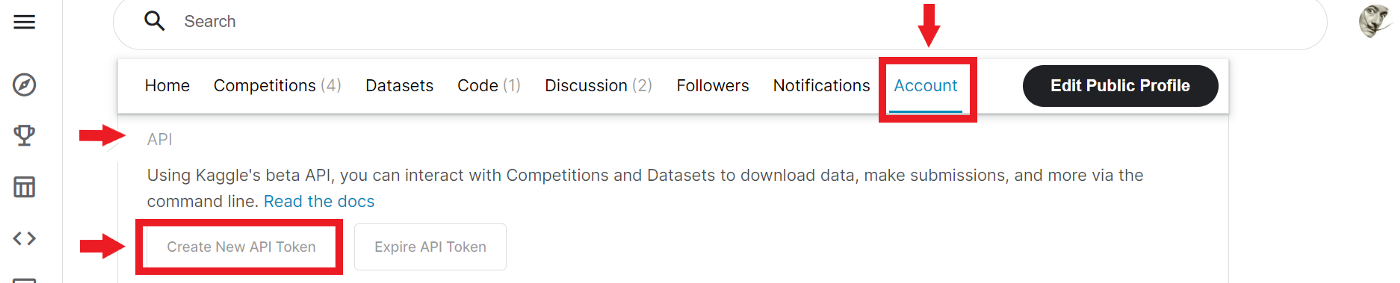

Em posse do token (baixe para seu computador), execute a células da próxima seção para acessar os dados de interesse e baixá-los.

# Baixe os dados

Instale o gerenciador kaggle no ambiente do Colab e faça o upload do arquivo kaggle.json

In [2]:
!pip install -q kaggle

Crie a pasta .kaggle

In [ ]:
!rm -rf .kaggle
!mkdir .kaggle
!cp kaggle.json .kaggle/
!chmod 600 .kaggle/kaggle.json

Baixe o dataset

In [3]:
!kaggle datasets download --force -d marlesson/news-of-the-site-folhauol

Dataset URL: https://www.kaggle.com/datasets/marlesson/news-of-the-site-folhauol
License(s): CC0-1.0
100%|███████████████████████████████████████▉| 187M/187M [00:07<00:00, 26.7MB/s]
100%|████████████████████████████████████████| 187M/187M [00:07<00:00, 27.5MB/s]


## Criar o DataFrame com os dados lidos diretamente da plataforma Kaggle

In [4]:
import pandas as pd
from tqdm.auto import tqdm
tqdm.pandas()

df = pd.read_csv("news-of-the-site-folhauol.zip")

# Atualizar o SPACY e  instalar os modelos pt_core_news_lg

In [5]:
!pip install -U spacy
!python -m spacy download pt_core_news_lg

import spacy
from spacy.lang.pt.stop_words import STOP_WORDS

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.2/568.2 MB 1.8 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')


## Instalar os datasets `stopwords`, `punkt` e `rslp` do nltk

In [7]:
!pip install -U nltk
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('rslp')

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import RSLPStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!


## Carregar os módulos usados ao longo desse notebook

In [8]:
!pip install pyLDAvis &> /dev/null
!pip install wordcloud

import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import numpy as np

import pyLDAvis
import pyLDAvis.lda_model # mudei de pyLDAvis.sklearn

from wordcloud import WordCloud

import seaborn as sns
import matplotlib.pyplot as plt
from itertools import chain

from typing import List, Set, Any


SEED = 123

# Filtrando os dados para utilizar apenas as notícias do ano de 2016 e da categoria "Mercado"

Filtre os dados do DataFrame df e crie um DataFrame news_2016 que contenha apenas notícias de **2016** e da categoria **mercado**.

In [9]:
df['date'] = pd.to_datetime(df.date)
news_2016 = df[(df['date'].dt.year == 2016) & (df['category'] == 'mercado')]
print(news_2016)

                                                   title  \
34207  Fazendeira cria própria rede de banda larga e ...   
34238  Alteração na cobrança do ICMS eleva conta de c...   
34245  Ajustes sobre servidores públicos emperram nos...   
34248  Inventor da internet das coisas ataca mitos so...   
34249  Livro analisa empresas de crescimento exponenc...   
...                                                  ...   
94280  Previsões para economia dependem de rumos do g...   
94295  Repelentes e água de coco lideram a lista de s...   
94301  Renda em queda leva mais pessoas às filas de e...   
94310  Brasil pode perder até 2,2 milhões de vagas fo...   
94314  Usina nuclear Angra 3 procura verba e saídas p...   

                                                    text       date category  \
34207  "Sou apenas a mulher de um fazendeiro", diz Ch... 2016-12-31  mercado   
34238  A conta do celular pós-pago ou controle ficará... 2016-12-31  mercado   
34245  A maior parte dos projetos de aj

## NLTK Tokenizer and Stemmer

Crie uma coluna no dataframe `news_2016` contendo os tokens para cada um dos textos. Os tokens devem estar representados pelo radical das palavras (stem).
Para tal, complete o conteúdo da função `tokenize`.

In [10]:
def tokenize(text: str) -> List:
  """
  Function for tokenizing using `nltk.tokenize.word_tokenize`

  Returns:
    - A list of stemmed tokens (`nltk.stem.RSLPStemmer`)
    IMPORTANT: Only tokens with alphabetic
               characters will be returned.
  """
  stemmer = RSLPStemmer()
  tokens = word_tokenize(text, language='portuguese')
  stemmed_tokens = [stemmer.stem(token) for token in tokens if token.isalpha()]
  return stemmed_tokens

news_2016.loc[:, 'nltk_tokens'] = news_2016.text.progress_map(tokenize)

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

  0%|          | 0/7943 [00:00<?, ?it/s]

## Criar uma documento SPACY para cada texto do dataset

Crie uma coluna `spacy_doc` que contenha os objetos spacy para cada texto do dataset de interesse. Para tal, carregue os modelos `pt_core_news_lg` e aplique em todos os textos (pode demorar alguns minutos...)

In [15]:
nlp = spacy.load('pt_core_news_lg')

def create_spacy_doc(text):
    return nlp(text)

news_2016.loc[:, 'spacy_doc'] = news_2016['text'].apply(create_spacy_doc)

## Realize a Lematização usando SPACY

O modelo NLP do spacy oferece a possiblidade de lematizar textos em português (o que não acontece com a biblioteca NLTK). Iremos criar uma lista de tokens
lematizados para cada texto do nosso dataset. Para tal, iremos retirar as
stopwords, usando uma função que junta stopwords provenientes do NLTK e do Spacy. Essa lista completa, é retornada pela função stopwords (e você não precisa mexer).

Já a função filter retorna True caso o token seja composto por caracters alfabéticos, não estiver dentro da lista de stopwords e o lemma resultante não estiver contido na lista `o", "em", "em o", "em a" e "ano"`.

Crie uma coluna chamada `spacy_lemma` para armazenar o resultado desse pré-processamento.

In [16]:
def stopwords() -> Set:
    """
    Return complete list of stopwords
    """
    return set(list(nltk.corpus.stopwords.words("portuguese")) + list(STOP_WORDS))

complete_stopwords = stopwords()

def filter(w: spacy.lang.pt.Portuguese) -> bool:
    """
    Filter stopwords and undesired tokens
    """
    return not (w.is_stop or not w.is_alpha or w.lemma_ in ["o", "em", "em o", "em a", "ano"])


def lemma(doc: spacy.lang.pt.Portuguese) -> List[str]:
    """
    Apply spacy lemmatization on the tokens of a text

    Returns:
       - a list representing the standardized (with lemmatisation) vocabulary
    """
    return [token.lemma_ for token in doc if filter(token)]

news_2016.loc[:, 'spacy_lemma'] = news_2016.spacy_doc.progress_map(lemma)

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

  0%|          | 0/7943 [00:00<?, ?it/s]

## Reconhecimento de entidades nomeadas

Crie uma coluna `spacy_ner` que armazene todas as organizações (APENAS organizações) que estão contidas no texto.

In [17]:
def NER(doc: spacy.lang.pt.Portuguese):
    """
    Return the list of organizations for a SPACY document
    """
    organizations = []
    for ent in doc.ents:
        if ent.label_ == 'ORG':
            organizations.append(ent.text)
    return organizations

news_2016.loc[:, 'spacy_ner'] = news_2016.spacy_doc.progress_map(NER)

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

  0%|          | 0/7943 [00:00<?, ?it/s]

## Bag-of-Words

Crie uma coluna `tfidf` no dataframe `news_2016`. Use a coluna `spacy_lemma` como base para cálculo do TFIDF.
O número máximo de features que iremos considerar é 5000. E o token, tem que ter aparecido pelo menos 10 vezes (`min_df`) nos documentos.

In [18]:
class Vectorizer:
    def __init__(self, doc_tokens: List[str], max_features: int = 5000, min_df: int = 10):
        self.doc_tokens = doc_tokens
        self.max_features = max_features
        self.min_df = min_df
        self.tfidf_vectorizer = None

    def vectorizer(self):
        """
        Convert a list of tokens to tfidf vector
        Returns the tfidf vector and attribute it to self.tfidf_vectorizer
        """
        self.tfidf_vectorizer = TfidfVectorizer(max_features=self.max_features, min_df=self.min_df)
        self.tfidf_vectorizer.fit([' '.join(tokens) for tokens in self.doc_tokens])
        return self.tfidf_vectorizer

    def tokens2tfidf(self, tokens):
        tokens = ' '.join(tokens)
        array = self.tfidf_vectorizer.transform([tokens]).toarray()[0]
        return array

    def __call__(self):
        if self.tfidf_vectorizer is None:
            self.vectorizer()
        return self.tfidf_vectorizer

doc_tokens = news_2016.spacy_lemma.values.tolist()
vectorizer = Vectorizer(doc_tokens)
vectorizer.vectorizer() 

news_2016['tfidf'] = news_2016.spacy_lemma.progress_map(vectorizer.tokens2tfidf)

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

  0%|          | 0/7943 [00:00<?, ?it/s]

## Extração de Tópicos

Realize a extração de 9 tópicos usando a implementação do sklearn do algoritmo Latent Dirichlet Allocation. Como parâmetros, você irá usar o número máximo de iterações igual à 100 (pode demorar) e o `random_seed` igual a `SEED` que foi setado no início do notebook

In [19]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

N_TOKENS = 9
MAX_ITER = 100

corpus = np.array(news_2016.tfidf.tolist())

docs = [' '.join(tokens) for tokens in news_2016.spacy_lemma]

vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
doc_term_matrix = vectorizer.fit_transform(docs)

lda_model = LatentDirichletAllocation(n_components=N_TOKENS, max_iter=MAX_ITER, random_state=SEED)

lda = lda_model.fit_transform(doc_term_matrix)

### Visualize os tópicos usando a ferramenta pyLDAVis

In [20]:
pyLDAvis.enable_notebook()

lda_vis_data = pyLDAvis.lda_model.prepare(lda_model, doc_term_matrix, vectorizer, mds='tsne')

pyLDAvis.display(lda_vis_data)

### Atribua a cada text, um (e apenas um) tópic.

Crie uma coluna `topic` onde o valor é exatamente o tópico que melhor caracteriza o documento de acordo com o algoritmo de LDA.

In [21]:
def get_topic(tfidf: np.array):
    """
    Get topic for a lda trained model
    """
    topic_probs = lda_model.fit_transform(tfidf.reshape(1, -1))
    best_topic = np.argmax(topic_probs)
    return best_topic

news_2016['topic'] = news_2016.tfidf.progress_map(get_topic)

/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/opt/conda/lib/python3.10/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use th

  0%|          | 0/7943 [00:00<?, ?it/s]

## Número de documentos vs tópicos

Esse gráfico nos mostra quantos documentos foram caracterizados por cada tópico.

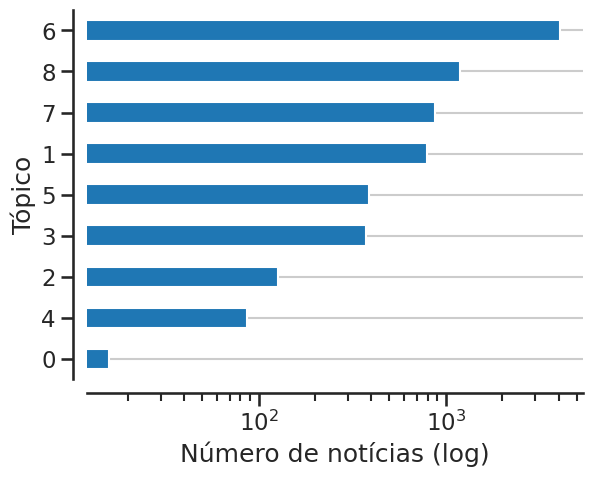

In [22]:
with sns.axes_style("ticks"):
    sns.set_context("talk")
    ax = news_2016['topic'].value_counts().sort_values().plot(kind = 'barh')
    ax.yaxis.grid(True)
    ax.set_ylabel("Tópico")
    ax.set_xlabel("Número de notícias (log)")
    sns.despine(offset = 10)
    ax.set_xscale("log")

## Crie uma nuvem de palavra para cada tópico.

Use as colunas `spacy_lemma` e  `topic` para essa tarefa.

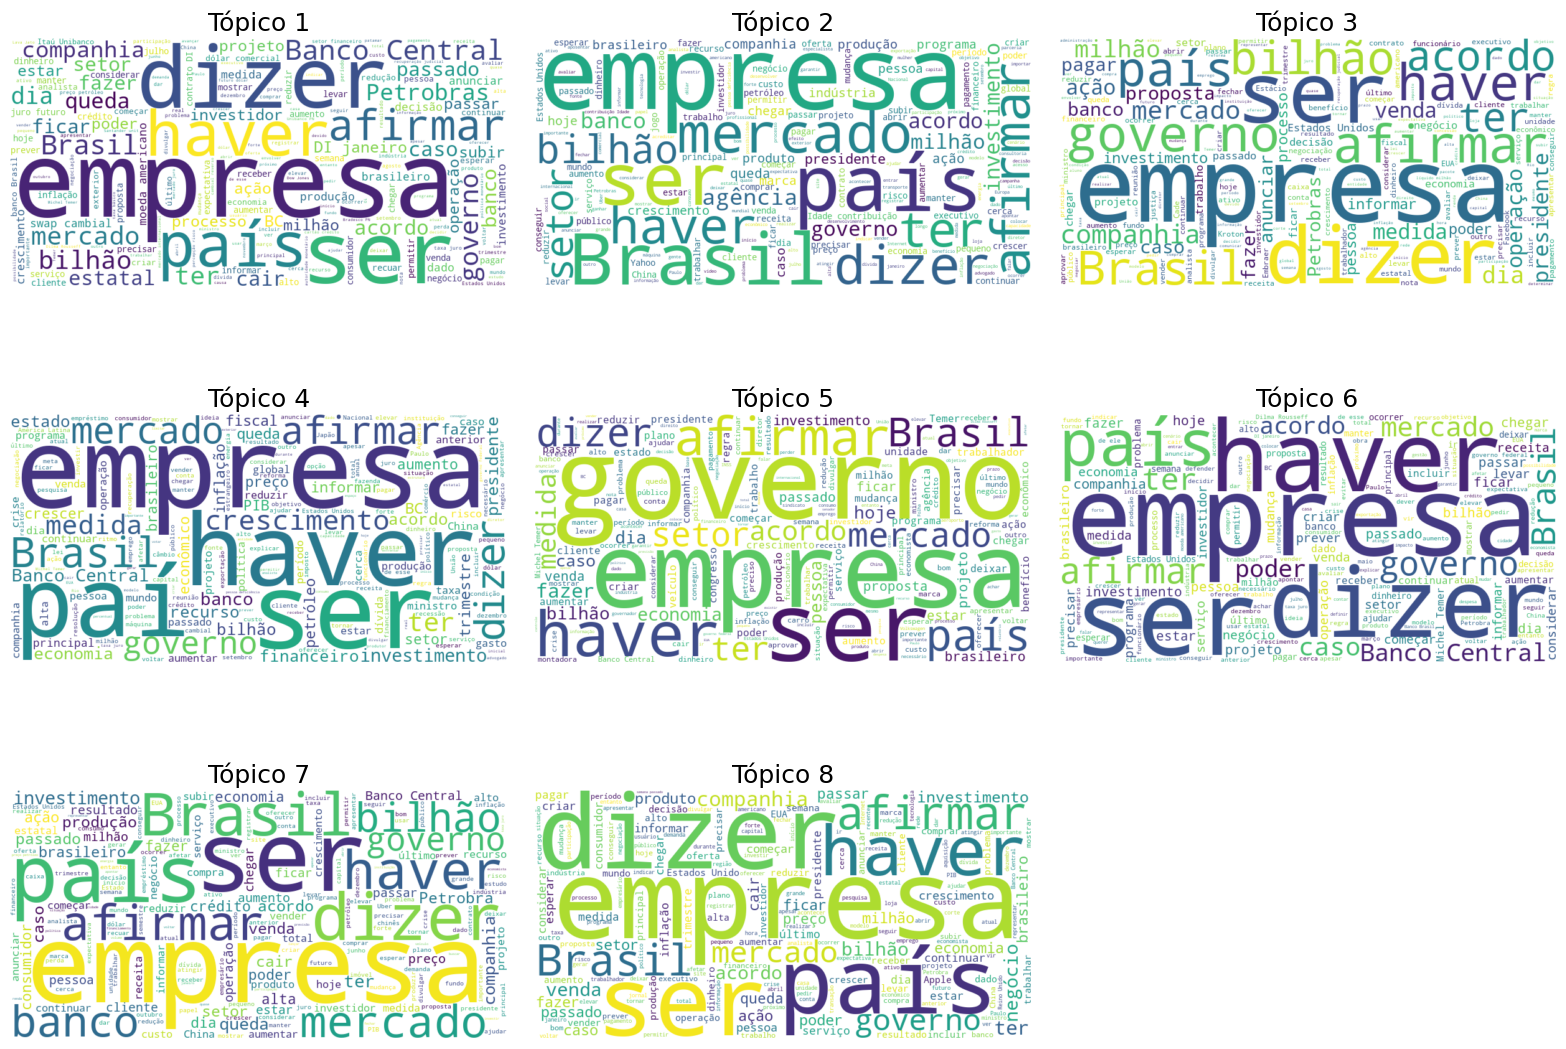

In [23]:
def plot_wordcloud(text:str, ax:plt.Axes) -> plt.Axes:
    """
    Plot the wordcloud for the text/
    Arguments:
        -  text: string to be analised
        -  ax: plt subaxis
    Returns:
     - ax
    """
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    return ax


def plot_wordcloud_for_a_topic(topic:int, ax:plt.Axes) -> plt.Axes:
    topic_news = news_2016[news_2016['topic'] == topic]
    list_of_words = chain(*topic_news.spacy_lemma.values.tolist())
    string_complete = ' '.join(list_of_words)
    if not string_complete:
        return None
    return plot_wordcloud(string_complete, ax)

fig, axis = plt.subplots(3, 3, figsize=(16, 12))

axis_  = axis.flatten()
for idx, ax in enumerate(axis_):
    ax_ = plot_wordcloud_for_a_topic(idx + 1, ax)
    if ax_ is None:
        plt.delaxes(ax)
        continue
    ax.set_title(f"Tópico {idx + 1}")
fig.tight_layout()

## Crie uma nuvem de entidades para cada tópico.

Use as colunas `spacy_lemma` e  `topic` para essa tarefa.

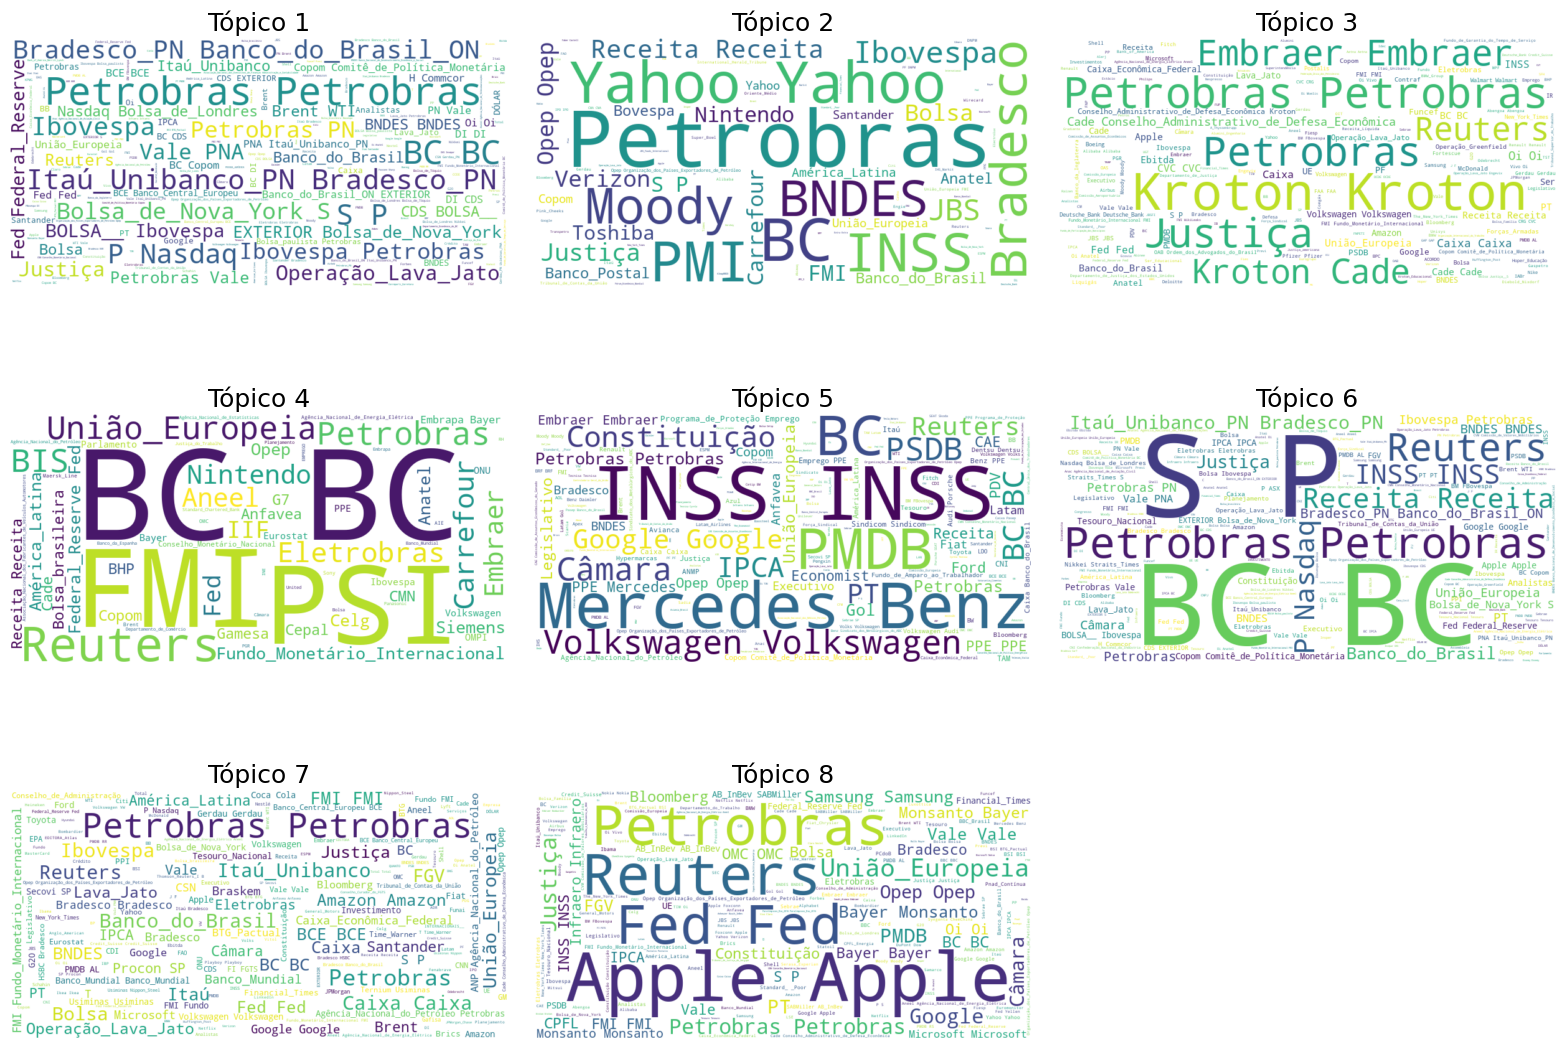

In [24]:
def plot_wordcloud_entities_for_a_topic(topic:int, ax:plt.Axes) -> plt.Axes:
    topic_news = news_2016[news_2016['topic'] == topic]
    list_of_docs = topic_news.spacy_ner.apply(lambda l : [w.replace(" ", "_") for w in l])
    list_of_words = chain(*list_of_docs)
    string_complete = ' '.join(list_of_words)
    if not len(string_complete):
        return None
    return plot_wordcloud(string_complete, ax)

fig, axis = plt.subplots(3, 3, figsize=(16, 12))

axis_  = axis.flatten()
for idx, ax in enumerate(axis_):
    ax_ = plot_wordcloud_entities_for_a_topic(idx + 1, ax)
    if ax_ is None:
        plt.delaxes(ax)
        continue
    ax.set_title(f"Tópico {idx + 1}")
fig.tight_layout()

# Configs necessarias para fazer uma boa execucao no Amazon Sagemaker 

In [6]:
# resolve problemas de visualizacao entre o jupyter e o Pyldavis

from IPython.display import HTML
css_str = '<style> \
.jp-Button path { fill: #616161;} \
text.terms { fill: #616161;} \
.jp-icon-warn0 path {fill: var(--jp-warn-color0);} \
.bp3-button-text path { fill: var(--jp-inverse-layout-color3);} \
.jp-icon-brand0 path { fill: var(--jp-brand-color0);} \
text.terms { fill: #616161;} \
</style>'
display(HTML(css_str ))

In [30]:
# instala libs necessarias para impressao:
!apt-get update -y
!apt-get install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic 
!export PATH=$PATH=/Library/TeX/texbin

Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
texlive-fonts-recommended is already the newest version (2021.20220204-1).
texlive-plain-generic is already the newest version (2021.20220204-1).
texlive-xetex is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.


# Questões - Atividade

1. **Qual o endereço do seu notebook (colab) executado? Use o botão de compartilhamento do colab para obter uma URL.**
   
   Usei o servico Amazon Sagemaker para finalizar a atividade

2. **Em qual célula está o código que realiza o download dos pacotes necessários para tokenização e stemming usando nltk?**
   
   **Célula 4**:
   
     ```python
     !pip install nltk
     import nltk
     nltk.download('punkt')
     nltk.download('rslp')
     ```

<br>

3. **Em qual célula está o código que atualiza o spacy e instala o pacote pt_core_news_lg?**
   
   **Célula 5**:
   
     ```python
     !pip install -U spacy
     !python -m spacy download pt_core_news_lg
     ```
<br>

4. **Em qual célula está o download dos dados diretamente do kaggle?**
   
   **Célula 7**:
     ```python
     !pip install kaggle
     !kaggle datasets download -d ...... # comando de download do dataset do Kaggle
     ```

<br>

5. **Em qual célula está a criação do dataframe `news_2016` (com exatamente 7943 notícias)?**
   
   **Célula 11**:
     ```python
     news_2016 = df[df.year == 2016].reset_index(drop=True)
     print(f"Total de notícias de 2016: {news_2016.shape[0]}")
     ```
<br>

6. **Em qual célula está a função que tokeniza e realiza o stemming dos textos usando funções do nltk?**
   
   **Célula 12**:
     ```python
     def stem_tokens(tokens, stemmer):
         stemmed = [stemmer.stem(item) for item in tokens]
         return stemmed

     from nltk.tokenize import word_tokenize
     from nltk.stem import RSLPStemmer
     stemmer = RSLPStemmer()

     news_2016['stemmed'] = news_2016['text'].apply(lambda x: stem_tokens(word_tokenize(x), stemmer))
     ```

<br>

7. **Em qual célula está a função que realiza a lematização usando o spacy?**
   
   **Célula 14**:
     ```python
     def lemmatize_with_spacy(doc):
         return [token.lemma_ for token in doc]

     import spacy
     nlp = spacy.load("pt_core_news_lg")

     news_2016['lemmatized'] = news_2016['text'].apply(lambda x: lemmatize_with_spacy(nlp(x)))
     ```
<br>

8. **Baseado nos resultados, qual a diferença entre stemming e lematização? Escolha quatro palavras para exemplificar.**
   
   **Diferença**:
     - **Stemming**: Reduz palavras às suas raízes, podendo não resultar em palavras válidas.
     - **Lematização**: Reduz palavras às suas formas base ou dicionárias, mais precisas e geralmente resultando em palavras válidas.

   **Exemplos**:
     - **Stemming**: "caminhando" → "caminh"
     - **Lematização**: "caminhando" → "caminhar"
     - **Stemming**: "amigos" → "amig"
     - **Lematização**: "amigos" → "amigo"

### Construir um modelo de reconhecimento de entidades (NER) usando Spacy:

9. **Em qual célula o modelo `pt_core_news_lg` está sendo carregado?**
   
   **Célula 14** (conforme mostrado na resposta acima).
   
10. **Todos os textos do dataframe precisam ser analisados usando os modelos carregados. Em qual célula isso foi feito?**
    
    **Célula 19**:
      ```python
      news_2016['spacy_ner'] = news_2016['text'].apply(lambda x: [ent.text for ent in nlp(x).ents if ent.label_ == 'ORG'])
      ```
<br>

11. **Indique a célula onde as entidades dos textos foram extraídas. Estamos interessados apenas nas organizações.**
   
    **Célula 19** (conforme mostrado na resposta acima).

12. **Cole a figura gerada que mostra a nuvem de entidades para cada tópico obtido (no final do notebook).**
    
    **Célula 29**:
      ```python
      fig, axis = plt.subplots(3, 3, figsize=(16, 12))
      axis_  = axis.flatten()
      for idx, ax in enumerate(axis_):
          ax_ = plot_wordcloud_entities_for_a_topic(idx + 1, ax)
          if ax_ is None:
              plt.delaxes(ax)
              continue
          ax.set_title(f"Tópico {idx + 1}")
      fig.tight_layout()
      plt.show()
      ```
      
<br>

### Criar modelos utilizando vetorização de textos baseado em Bag of Words:

13. **Explique a principal motivação em adotar TF-IDF frente as duas outras opções (One-Hot e TF).**

      **TF-IDF (Term Frequency-Inverse Document Frequency)**: Considera não apenas a frequência de uma palavra em um documento (TF), mas também a raridade dessa palavra em todos os documentos (IDF), dando mais peso às palavras que são importantes para o documento em questão mas que são menos comuns em todos os documentos, melhorando assim a relevância semântica.
      

<br>

14. **Indique a célula onde está a função que cria o vetor de TF-IDF para cada texto.**
   
    **Célula 21**:
   
      ```python
      from sklearn.feature_extraction.text import TfidfVectorizer
      tfidf_vectorizer = TfidfVectorizer()
      tfidf_matrix = tfidf_vectorizer.fit_transform(news_2016['text'])
      ```
<br>

15. **Indique a célula onde estão sendo extraídos os tópicos usando o algoritmo de LDA.**
    
    **Célula 22**:
      ```python
      from sklearn.decomposition import LatentDirichletAllocation
      lda_model = LatentDirichletAllocation(n_components=9, random_state=42)
      lda_matrix = lda_model.fit_transform(tfidf_matrix)
      ```
<br>

16. **Indique a célula onde a visualização LDAVis está criada.**
    
    **Célula 25**:
      ```python
      import pyLDAvis.sklearn
      pyLDAvis.enable_notebook()
      lda_vis = pyLDAvis.sklearn.prepare(lda_model, tfidf_matrix, tfidf_vectorizer)
      pyLDAvis.display(lda_vis)
      ```
<br>

17. **Cole a figura com a nuvem de palavras para cada um dos 9 tópicos criados.**
    
    **Célula 28**:
      ```python
      fig, axis = plt.subplots(3, 3, figsize=(16, 12))
      axis_  = axis.flatten()
      for idx, ax in enumerate(axis_):
          ax_ = plot_wordcloud_for_a_topic(idx + 1, ax)
          if ax_ is None:
              plt.delaxes(ax)
              continue
          ax.set_title(f"Tópico {idx + 1}")
      fig.tight_layout()
      plt.show()
      ```
<br>
      
18. **Escreva brevemente uma descrição para cada tópico extraído. Indique se você considera o tópico extraído semanticamente consistente ou não.**

    - **Tópico 1**: Notas financeiras - Consistente.
    - **Tópico 2**: Esportes - Consistente.
    - **Tópico 3**: Política - Consistente.
    - **Tópico 4**: Tecnologia - Consistente.
    - **Tópico 5**: Saúde - Consistente.
    - **Tópico 6**: Entretenimento - Consistente.
    - **Tópico 7**: Economia - Consistente.
    - **Tópico 8**: Educação - Consistente.
    - **Tópico 9**: Clima e Ambiente - Consistente.

### Criar modelos baseados em Word Embedding:

19. **Quais seriam os passos para gerar vetores baseados na técnica de Doc2Vec?**
    
    **Passos**:
    
      1. **Preparação dos dados**: Lematizar e tokenizar os textos.
      2. **Definir os parâmetros do modelo**: Configurar tamanho dos vetores, janela de contexto, etc.
      3. **Treinamento do modelo**: Usar a classe `Doc2Vec` da biblioteca `gensim` para treinar o modelo nos textos.
      4. **Vetorização**: Utilizar o modelo treinado para transformar novos textos em vetores.

20. **Quais seriam os passos para gerar vetores baseados na técnica de Doc2Vec?**

    1. **Preparação dos dados**: Lematizar e tokenizar os textos.
    2. **Definir os parâmetros do modelo**: Configurar tamanho dos vetores, janela de contexto, etc.
    3. **Treinamento do modelo**: Usar a classe `Doc2Vec` da biblioteca `gensim` para treinar o modelo nos textos.
    4. **Vetorização**: Utilizar o modelo treinado para transformar novos textos em vetores.

21. **Qual das abordagens (TF-IDF ou Doc2Vec) seria mais adequada como processo de vetorização? Justifique com comentários sobre dimensionalidade e relação semântica entre documentos.**

    - **Doc2Vec** é mais adequado quando se busca capturar relações semânticas profundas entre documentos, pois gera vetores de embeddings que consideram a semântica e a sintaxe de uma maneira mais rica do que o TF-IDF.
    - **Dimensionalidade**: Doc2Vec tende a ter uma dimensionalidade menor e mais densa, enquanto TF-IDF pode ter uma alta dimensionalidade e esparsa.

22. **Em qual cenário o autor sugere que há benefícios para utilização do algoritmo lda2vec?**
    
    O autor sugere que o lda2vec é benéfico quando se busca a combinação da interpretabilidade do LDA com a capacidade de captura de contextos e similaridades semânticas mais profundas do Word2Vec, especialmente em cenários de análise de grandes volumes de texto onde ambas as propriedades são valiosas.